# Diffusion Models from HaggingFace

## Setup

The examples shown here require a GPU of at least 12GB VRAM; I am using a [NVIDIA RTX 3060](https://mikelsagardia.io/blog/mac-os-ubuntu-nvidia-egpu.html), but a NVIDIA T4 (typical in [Google Colab](https://colab.research.google.com/)) should work, too.

Note 1: Image generation models are quite large and consume much memory space. Therefore, we need to actively clear the memory allocation after each example.

Note 2: if we get *Out-of-memory* errors even though we empty the cache of the GPU, maybe an application got stuck and need to be removed; to that end, get its PID checking the apps which use the GPU:

```bash
nvidia-smi  # Get the PID
kill -9 <PID>
```

In [36]:
from diffusers import DiffusionPipeline, AutoPipelineForText2Image
from diffusers.utils import load_image, make_image_grid
import torch
import numpy as np
from PIL import Image

# For memory management
import gc

In [37]:
# Name of each GPU
for i in range(torch.cuda.device_count()):
    print(i, torch.cuda.get_device_name(i))

0 NVIDIA GeForce RTX 3060
1 NVIDIA T500


In [38]:
# Select GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [39]:
!nvidia-smi

Mon Nov 24 18:48:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA T500                    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8            N/A  / 5001W |       5MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Unconditional Image Generation

[HuggingFace > Task: Unconditional Image Generation](https://huggingface.co/models?pipeline_tag=unconditional-image-generation&library=diffusers&sort=trending)

[google/ddpm-celebahq-256](https://huggingface.co/google/ddpm-celebahq-256)

[diffusers/training_example.ipynb](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/training_example.ipynb)
`diffusers.UNet2DModel` trained on the [Butterflies Dataset](https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset).

In [ ]:
# Seed for reproducibility: for each new seed, we get a different image
rand_gen = torch.manual_seed(89608352)

# Celebrity image generation pipeline: google/ddpm-celebahq-256
model_name = 'google/ddpm-celebahq-256'

# This will download the model from HuggingFace Hub
# and move it to the selected device (GPU or CPU)
model = DiffusionPipeline.from_pretrained(model_name).to(device)

# Generate an image using the random seed: the output is a PIL image
image = model(generator=rand_gen).images[0]

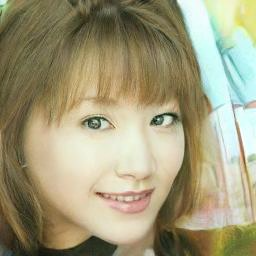

In [13]:
# Display the generated PIL image
image

## Conditional Generation: Text-to-Image

In [5]:
# Delete any existing pipeline and/or model
# If this doesn't work, restart the kernel
try:
    del model
except:
    pass

# Clear GPU cache
torch.cuda.empty_cache()
gc.collect()

100

In [16]:
prompt = """
A friendly humanoid robot sits at a wooden table in a bright, sunlit room, happily drawing on a sketchbook.
Soft light colors, landscape, peaceful, productive, and joyful atmosphere.
The robot is drawing an image of itself drawing, creating a recursive effect.
Large window in the background with greenery outside, warm natural lighting.
"""

### Stable Diffusion XL Turbo

In [6]:
# Load the SDXL-Turbo text-to-image pipeline
pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo", 
    torch_dtype=torch.float16, 
    variant="fp16"
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [14]:
# Seed for reproducibility
rand_gen = torch.manual_seed(148607185)

# Generate an image based on the text prompt
image = pipe(
    prompt=prompt, 
    num_inference_steps=1, # For this model you can use 1, but for normal Stable Diffusion you should use 25 or 50
    guidance_scale=1.0, # For this model 1 is fine, for normal Stable Diffusion you should use 6 or 7, or up to 10 or so
    negative_prompt=["overexposed", "underexposed"], 
    generator=rand_gen
).images[0]

  0%|          | 0/1 [00:00<?, ?it/s]

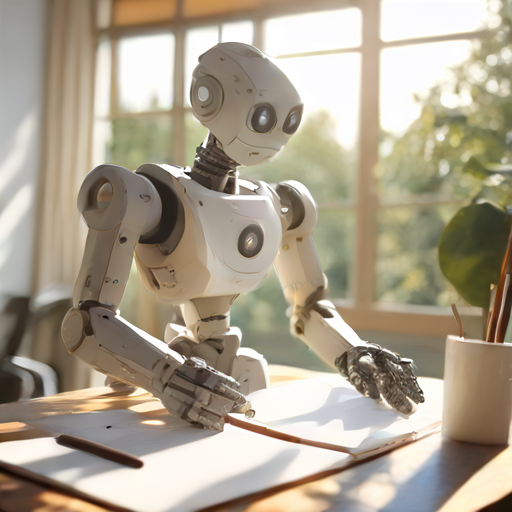

In [15]:
# Display the generated PIL image
image

### Playground V2

In [17]:
# Delete any existing pipeline and/or model
# If this doesn't work, restart the kernel
try:
    del pipe, model
except:
    pass

# Clear GPU cache
torch.cuda.empty_cache()
gc.collect()

83

In [18]:
# PlaygroundAI V2: not photorealistic, more artistic
pipe = AutoPipelineForText2Image.from_pretrained(
    "playgroundai/playground-v2-1024px-aesthetic",
    torch_dtype=torch.float16,
    use_safetensors=True,
    add_watermarker=False,
    variant="fp16"
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [19]:
# Seed for reproducibility
rand_gen = torch.manual_seed(148607185)

# Generate an image based on the text prompt
image  = pipe(prompt=prompt, guidance_scale=3.0, generator=rand_gen).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

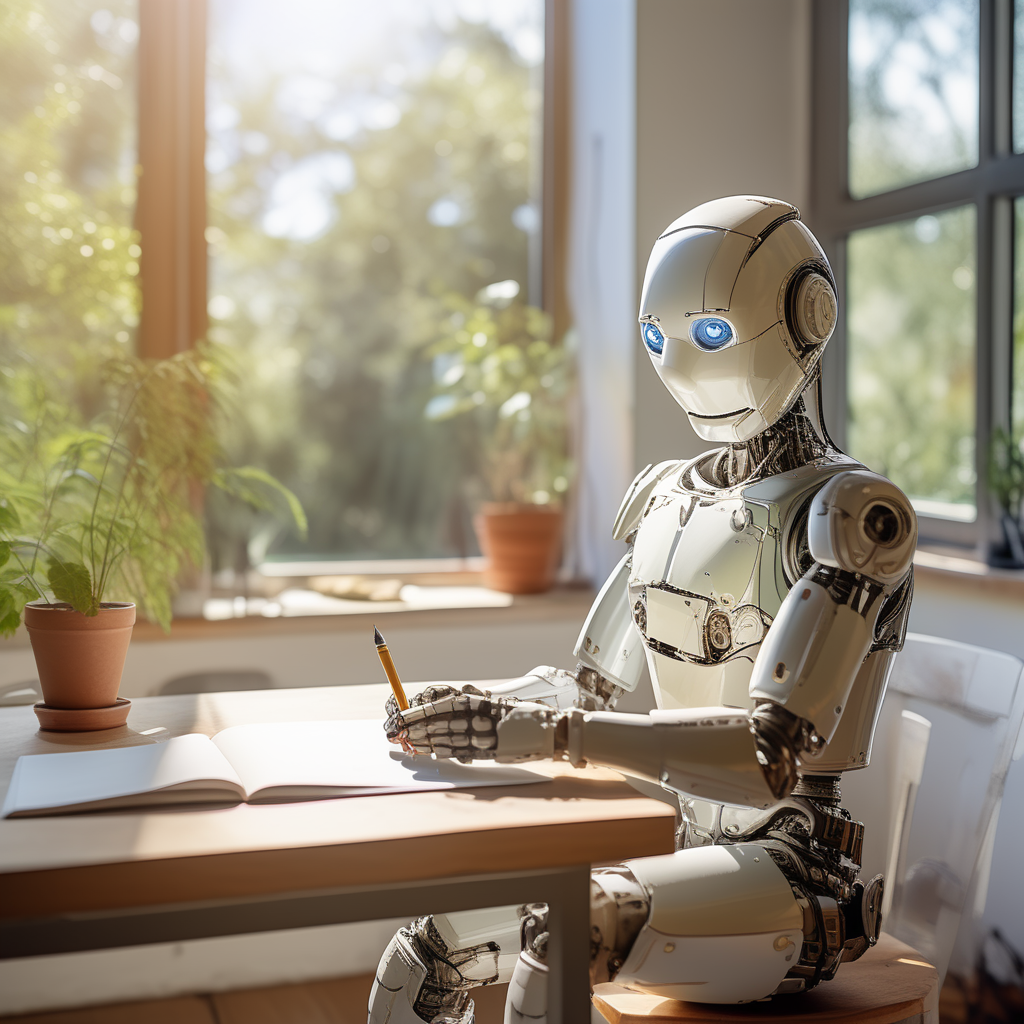

In [20]:
# Display the generated PIL image
image

## Conditional Generation: Image-to-Image

First, Stable Diffusion XL Turbo, then 

In [5]:
# Delete any existing pipeline and/or model
# If this doesn't work, restart the kernel
try:
    del pipe, model
except:
    pass

# Clear GPU cache
torch.cuda.empty_cache()
gc.collect()

100

In [6]:
pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo", 
    torch_dtype=torch.float16, 
    variant="fp16"
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
prompt = "A painting of a friendly dog painted by a child."

In [8]:
# Seed for reproducibility
rand_gen = torch.manual_seed(60785)

image  = pipe(
    prompt=prompt, 
    num_inference_steps=2,
    guidance_scale=2,
    generator=rand_gen
).images[0]

  0%|          | 0/2 [00:00<?, ?it/s]

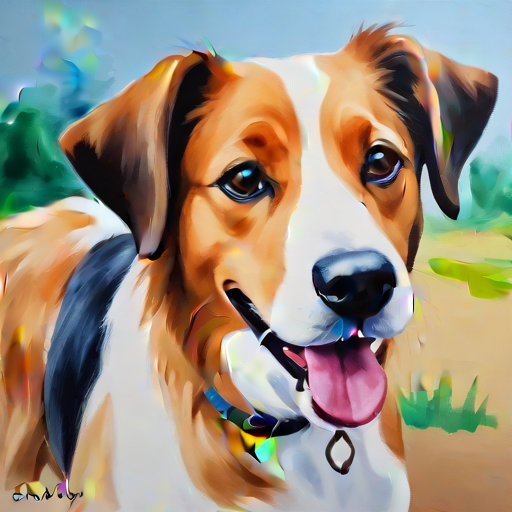

In [9]:
image

In [ ]:
image.save("../assets/dog_sketch.png")

In [11]:
from diffusers import KandinskyV22Img2ImgPipeline, KandinskyPriorPipeline

In [12]:
# Delete any existing pipeline and/or model
# If this doesn't work, restart the kernel
try:
    del pipe, model
except:
    pass

# Clear GPU cache
torch.cuda.empty_cache()
gc.collect()

80

In [13]:
prior_pipeline = KandinskyPriorPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-2-prior",
    torch_dtype=torch.float16,
    use_safetensors=True
).to(device)
pipe = KandinskyV22Img2ImgPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-2-decoder",
    torch_dtype=torch.float16,
    use_safetensors=True
).to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
image = Image.open("../assets/dog_sketch.png")
original_image = image.copy().resize((768, 768))

In [19]:
prompt = "A photo of a friendly dog. High details, realistic."
negative_prompt = "low quality, bad quality"

In [20]:
rand_gen = torch.manual_seed(678001)
image_embeds, negative_image_embeds = prior_pipeline(prompt, negative_prompt, generator=rand_gen).to_tuple()

  0%|          | 0/25 [00:00<?, ?it/s]

In [21]:
new_image = pipe(
    image=original_image, 
    image_embeds=image_embeds, 
    negative_image_embeds=negative_image_embeds, 
    height=768, 
    width=768, 
    strength=0.35,  # how much to follow the original image
    generator=rand_gen
).images[0]

  0%|          | 0/35 [00:00<?, ?it/s]

In [22]:
fig = make_image_grid([original_image.resize((512, 512)), new_image.resize((512, 512))], rows=1, cols=2)

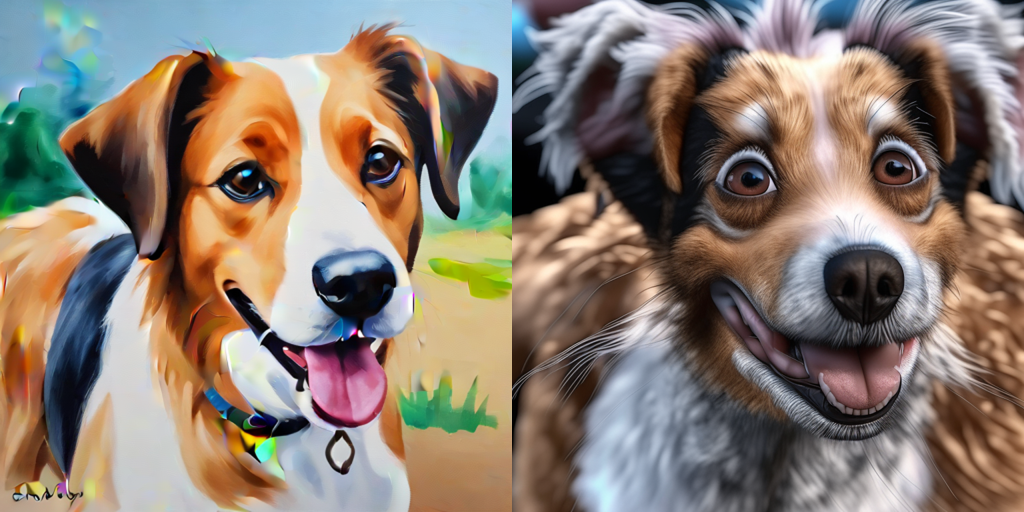

In [23]:
fig

## Conditional Generation: In-Painting

In [40]:
# Delete any existing pipeline and/or model
# If this doesn't work, restart the kernel
try:
    del pipe, model
except:
    pass

# Clear GPU cache
torch.cuda.empty_cache()
gc.collect()

140

In [41]:
import torch
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid

# Select GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

pipeline = AutoPipelineForInpainting.from_pretrained(
    "kandinsky-community/kandinsky-2-2-decoder-inpaint", torch_dtype=torch.float16
)
pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [42]:
# To avoid Out-of-memory errors
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [43]:
init_image = load_image("../assets/vermeer_girl_pearl_earring.jpg").resize((512, 512))
mask_image = load_image("../assets/vermeer_girl_pearl_earring_mask.png").resize((512, 512))

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

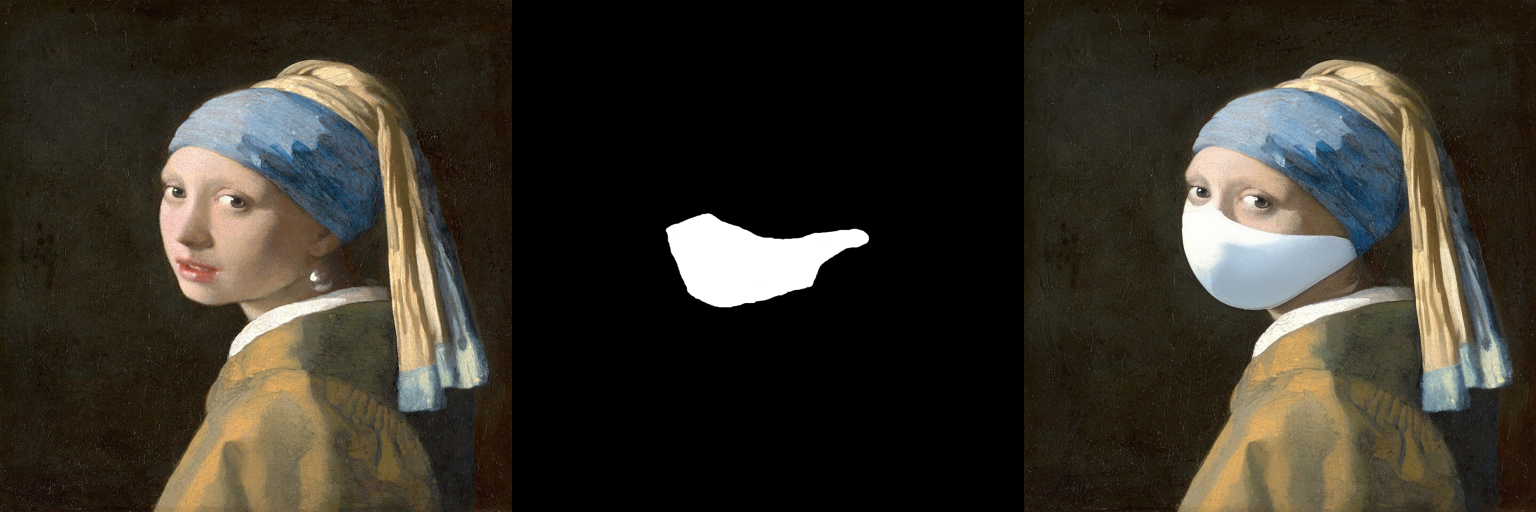

In [46]:
import matplotlib.pyplot as plt

prompt = "oil painting of a woman wearing a surgical mask, Vermeer"
negative_prompt = "bad anatomy, deformed, ugly, disfigured"

rand_gen = torch.manual_seed(74294536)
image = pipeline(prompt=prompt, negative_prompt=negative_prompt, image=init_image, mask_image=mask_image, generator=rand_gen, guidance_scale=1.5).images[0]
fig = make_image_grid([init_image, mask_image, image], rows=1, cols=3)
fig